### Load Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
# XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer

import statsmodels.api as sm

import shap

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = os.getcwd()
# get the csv file from the /Users/gan-m2/Credit Risk Modelling pipeline/data/3-data_processing_feature_selection
processed_csv_path = os.path.join(path, 'data', '3-data_processing_feature_selection', 'df_selected_features.csv')
df = pd.read_csv(processed_csv_path, index_col=0)
df.head()

,last_pymnt_d,int_rate,last_credit_pull_d,sub_grade,recoveries,last_pymnt_amnt,total_rec_prncp,out_prncp,out_prncp_inv,total_pymnt_inv,total_pymnt,target
0,Jan-15,10.65,Jan-16,B2,0.00,171.62,5000.00,0.0,0.0,5831.78,5861.071414,0
1,Apr-13,15.27,Sep-13,C4,117.08,119.66,456.46,0.0,0.0,1008.71,1008.710000,1
2,Jun-14,15.96,Jan-16,C5,0.00,649.91,2400.00,0.0,0.0,3003.65,3003.653644,0
3,Jan-15,13.49,Jan-15,C1,0.00,357.48,10000.00,0.0,0.0,12226.30,12226.302210,0
4,Jan-16,12.69,Jan-16,B5,0.00,67.79,2233.10,766.9,766.9,3242.17,3242.170000,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465867 entries, 0 to 465866
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   last_pymnt_d        465867 non-null  object 
 1   int_rate            465867 non-null  float64
 2   last_credit_pull_d  465867 non-null  object 
 3   sub_grade           465867 non-null  object 
 4   recoveries          465867 non-null  float64
 5   last_pymnt_amnt     465867 non-null  float64
 6   total_rec_prncp     465867 non-null  float64
 7   out_prncp           465867 non-null  float64
 8   out_prncp_inv       465867 non-null  float64
 9   total_pymnt_inv     465867 non-null  float64
 10  total_pymnt         465867 non-null  float64
 11  target              465867 non-null  int64  
dtypes: float64(8), int64(1), object(3)
memory usage: 46.2+ MB


### Transformed and encoded data

In [4]:
categorical_features = ['last_pymnt_d', 'last_credit_pull_d', 'sub_grade']
df_encoded = pd.get_dummies(df, columns=categorical_features)
df_encoded.head()

,int_rate,recoveries,last_pymnt_amnt,total_rec_prncp,out_prncp,out_prncp_inv,total_pymnt_inv,total_pymnt,target,last_pymnt_d_Apr-08,...,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
0,10.65,0.00,171.62,5000.00,0.0,0.0,5831.78,5861.071414,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15.27,117.08,119.66,456.46,0.0,0.0,1008.71,1008.710000,1,0,...,0,0,0,0,0,0,0,0,0,0
2,15.96,0.00,649.91,2400.00,0.0,0.0,3003.65,3003.653644,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13.49,0.00,357.48,10000.00,0.0,0.0,12226.30,12226.302210,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12.69,0.00,67.79,2233.10,766.9,766.9,3242.17,3242.170000,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np

def transform_features(df, log_features=[], z_score_features=[], robust_features=[], target_feature='target'):
    """
    Apply specified transformations to the given features of the DataFrame and return a DataFrame with
    only the transformed features and the target variable.

    Parameters:
    - df: pandas DataFrame, the original DataFrame.
    - log_features: list of strings, names of features to apply log transformation.
    - z_score_features: list of strings, names of features to apply z-score normalization.
    - robust_features: list of strings, names of features to apply robust scaling.
    - target_feature: string, the name of the target variable.

    Returns:
    - df_selected: pandas DataFrame, the DataFrame with only transformed features and the target variable.
    """
    df_transformed = df.copy()

    # Log transformation
    for feature in log_features:
        df_transformed[feature] = np.log1p(df_transformed[feature])

    # Z-score normalization
    for feature in z_score_features:
        scaler = StandardScaler()
        transformed_feature = scaler.fit_transform(df_transformed[feature].values.reshape(-1, 1)).flatten()
        df_transformed[feature] = transformed_feature

    # Robust scaling
    for feature in robust_features:
        scaler = RobustScaler()
        transformed_feature = scaler.fit_transform(df_transformed[feature].values.reshape(-1, 1)).flatten()
        df_transformed[feature] = transformed_feature

    # Select only the transformed features and the target variable
    transformed_features = log_features + z_score_features + robust_features
    df_selected = df_transformed[transformed_features + [target_feature]]

    return df_selected


In [6]:
# get columne name of float64 type
df_float64 = df.select_dtypes(include=['float64'])
continuous_feature_list = df_float64.columns.to_list()
continuous_feature_list

# based on the result from EDA and data processing, we know that annual_inc can be used as the feature for z-score normalization
# and the rest of them will be used as the feature for log transformation

# z_score_features = ['annual_inc']
# log_features = 

transformed_df = transform_features(df_encoded, log_features=continuous_feature_list, target_feature='target')
transformed_df.head()

,int_rate,recoveries,last_pymnt_amnt,total_rec_prncp,out_prncp,out_prncp_inv,total_pymnt_inv,total_pymnt,target
0,2.455306,0.000000,5.151093,8.517393,0.00000,0.00000,8.671249,8.676258,0
1,2.789323,4.771362,4.792977,6.125689,0.00000,0.00000,6.917418,6.917418,1
2,2.830858,0.000000,6.478371,7.783641,0.00000,0.00000,8.007916,8.007918,0
3,2.673459,0.000000,5.881873,9.210440,0.00000,0.00000,9.411426,9.411427,0
4,2.616666,0.000000,4.231058,7.711594,6.64366,6.64366,8.084307,8.084307,0


In [7]:
# replace the original continuous features with the transformed features
df_encoded[continuous_feature_list] = transformed_df[continuous_feature_list]
df_encoded.head()

,int_rate,recoveries,last_pymnt_amnt,total_rec_prncp,out_prncp,out_prncp_inv,total_pymnt_inv,total_pymnt,target,last_pymnt_d_Apr-08,...,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
0,2.455306,0.000000,5.151093,8.517393,0.00000,0.00000,8.671249,8.676258,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.789323,4.771362,4.792977,6.125689,0.00000,0.00000,6.917418,6.917418,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2.830858,0.000000,6.478371,7.783641,0.00000,0.00000,8.007916,8.007918,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.673459,0.000000,5.881873,9.210440,0.00000,0.00000,9.411426,9.411427,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.616666,0.000000,4.231058,7.711594,6.64366,6.64366,8.084307,8.084307,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split data into training, validation, and test sets

In [8]:
# Define features (X) and target (y)
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# Split into training + validation (90%) and test (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Split training + validation into training (70% of 90%) and validation (20% of 90%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)


# 1. Logistic Regression model 

In [9]:
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print('Validation Accuracy:', val_accuracy)

# Predict probabilities for the validation set
y_val_proba = model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class
# Calculate AUC for the validation set
val_auc = roc_auc_score(y_val, y_val_proba)
print('Validation AUC:', val_auc)

Validation Accuracy: 0.9899220812673063
Validation AUC: 0.9831771296784246


# 2. SHAP value for Logistic Regression model

In [10]:
# Initialize the SHAP explainer
explainer = shap.Explainer(model, X_train)
# Compute SHAP values for the test set
shap_values = explainer(X_test)

## 2.1 Summary Plot

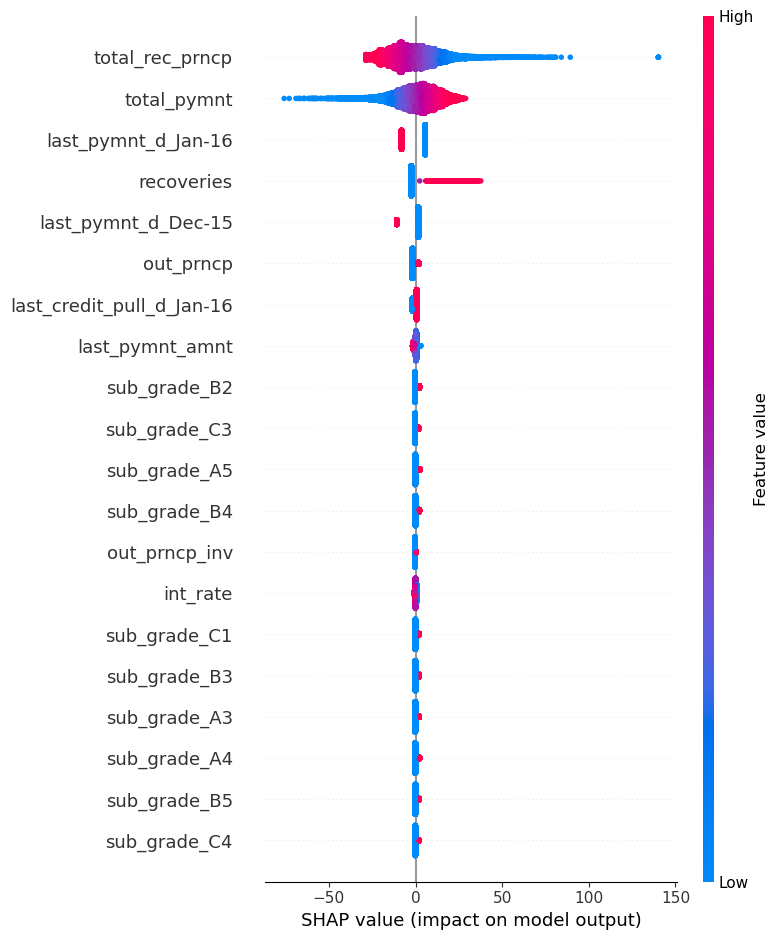

In [11]:
# Set the figure size for the summary plot
plt.figure(figsize=(10, 6))  # Adjust the dimensions as needed
shap.summary_plot(shap_values, X_test)

## 2.2 Waterfall Plot

Waterfall plot is a local explanation method. It shows how each feature contributes to push the model output from the base value (the average model output over the training dataset we passed) to the model output for a particular prediction.

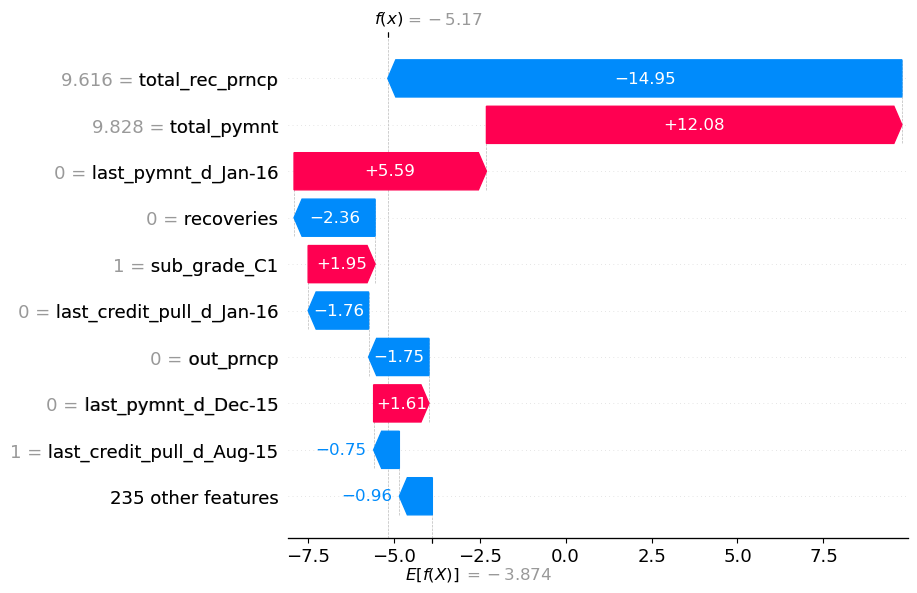

In [12]:
shap.plots.waterfall(shap_values[0]) 

- **Base Value (f(x))**: This is the average model output over the training dataset or the expected value of the model output (E[f(X)]). For the model, it's -5.17.

- **Output Value (E[f(X)])**: At the bottom of the plot, we see E[f(X)] = -3.874, which is the model's output for this specific instance after all SHAP values are applied. This value represents the log-odds of the prediction in the context of a logistic regression model.

- **Feature Contributions**: Each row shows a feature's contribution to shifting the base value towards the final model output. The length of the bar represents the magnitude of the feature's impact, and the color represents the direction (blue for decreasing the prediction, red for increasing the prediction).

For instance:
- `total_rec_prncp` (value = 9.616) significantly decreases the model's output by -14.95, suggesting that as the total received principal increases, the likelihood of the target event (default in this case) decreases.
- `total_pymnt` (value = 9.828) increases the model's output by +12.08, indicating that higher total payments are associated with a higher likelihood of the target event(default).
- `last_pymnt_d_Jan-16` (value = 0) and other features with a value of 0 have varying impacts on the prediction, both positive and negative.

The plot also shows that the rest of the features not listed individually ("235 other features") collectively decrease the prediction by -0.96, which is slightly affected by the features listed individually. It leaves us with more space to explore the impact of these features.(or to be more specific, the feature engineering can be done further to improve the model performance)

## 2.3 Scatter plot

Since waterfall plot is a local explanation method, we can only see the contribution of each feature for a particular prediction. 

If we want to see the relationship between SHAP value and feature value, we can use scatter plot. 

Thus, the scatter plot is used to observe the dynamic changes of variables.

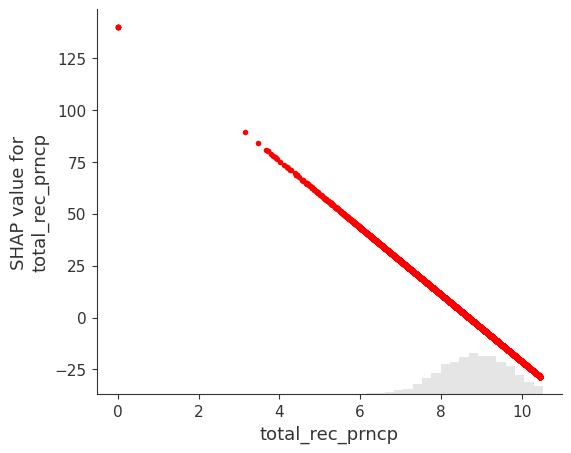

In [13]:
# dive into the total_rec_prcnp and total_pymnt features
shap.plots.scatter(shap_values[:, 'total_rec_prncp'], color='red')

The downward trend line in the scatter plot indicates a negative correlation between the total_rec_prncp feature and the model's output. 

As total_rec_prncp increases, its SHAP value decreases, suggesting that higher values of this feature push the model's prediction towards the negative class (which, in the lending scenario, it represent the likelihood of not defaulting).

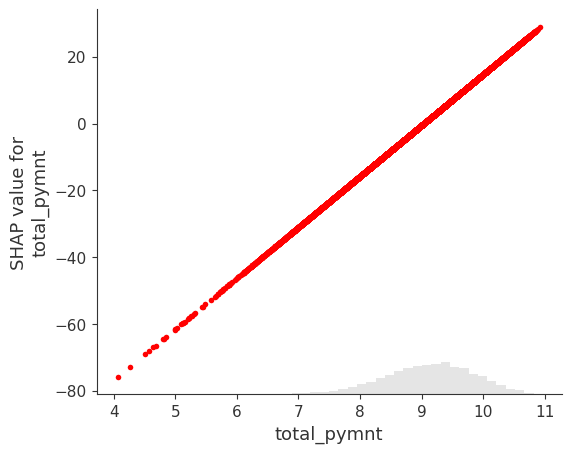

In [14]:
shap.plots.scatter(shap_values[:, 'total_pymnt'], color='red')

The upward trend line in the scatter plot indicates a negative correlation between the total_pymnt feature and the model's output. 

As total_pymnt increases, its SHAP value increases, suggesting that higher values of this feature push the model's prediction towards the npositive class (which, in the lending scenario, it represent the likelihood of defaulting).

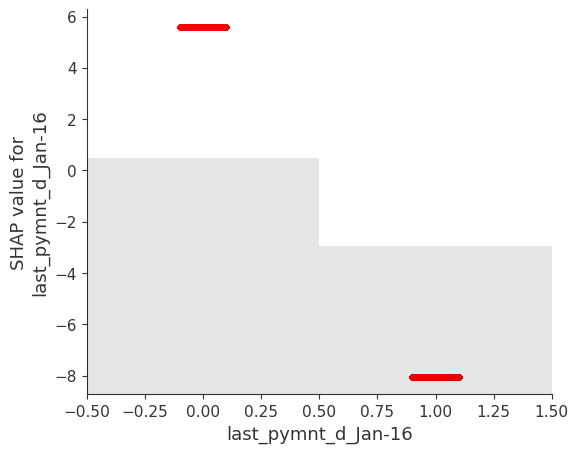

In [15]:
# # check the last_pymnt_d_Jan-16
shap.plots.scatter(shap_values[:, 'last_pymnt_d_Jan-16'], color='red')

In this plot, we can observe that when last_pymnt_d_Jan-16 is 1 (meaning the last payment was in January 2016), the SHAP values are positive, indicating that this is associated with an increased likelihood of the positive class outcome, which is default.

Conversely, when last_pymnt_d_Jan-16 is 0, the SHAP values do not show a consistent increase or decrease in the likelihood of default, as indicated by the mix of positive and negative SHAP values around zero. This suggests that the absence of a payment in January 2016 does not have a uniform effect on the prediction of default, and its influence may be context-dependent based on the values of other features.

# 3. XGBoostClassifier model

In [17]:
xgb_model = XGBClassifier(random_state=42, eval_metric=['auc', 'error'])
xgb_model.fit(X_train, y_train)
# get result from the validation set
y_val_pred = xgb_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print('Validation Accuracy:', val_accuracy)
# Predict probabilities for the validation set
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class
# Calculate AUC for the validation set
val_auc = roc_auc_score(y_val, y_val_proba)
print('Validation AUC:', val_auc)

Validation Accuracy: 0.9941185309206431
Validation AUC: 0.993643893822511


The XGBoostClassifier model has a higher accuracy score and AUC score than the Logistic Regression model.

The reason why the XGBoostClassifier model has a higher accuracy score and AUC score than the Logistic Regression model is that the XGBoostClassifier model is a more complex model than the Logistic Regression model, it has two major advantages in this case:
1. XGBClassifier is an implementation of gradient boosting, an ensemble learning technique that combines the predictions from multiple decision trees to make more accurate predictions than any individual tree could. This often results in improved performance over single-model approaches like Logistic Regression.
2. XGBClassifier can capture complex non-linear relationships between features and the target variable, which might be present in your data. Logistic Regression, being a linear model, can only capture linear relationships unless feature engineering is used to explicitly model non-linearities.


# 4. SHAP value for XGBClassifier model

In [18]:
# Initialize the SHAP explainer
xgb_model_explainer = shap.Explainer(xgb_model, X_train)
# Compute SHAP values for the test set
xgb_model_shap_values = explainer(X_test)

## 4.1 Summary Plot

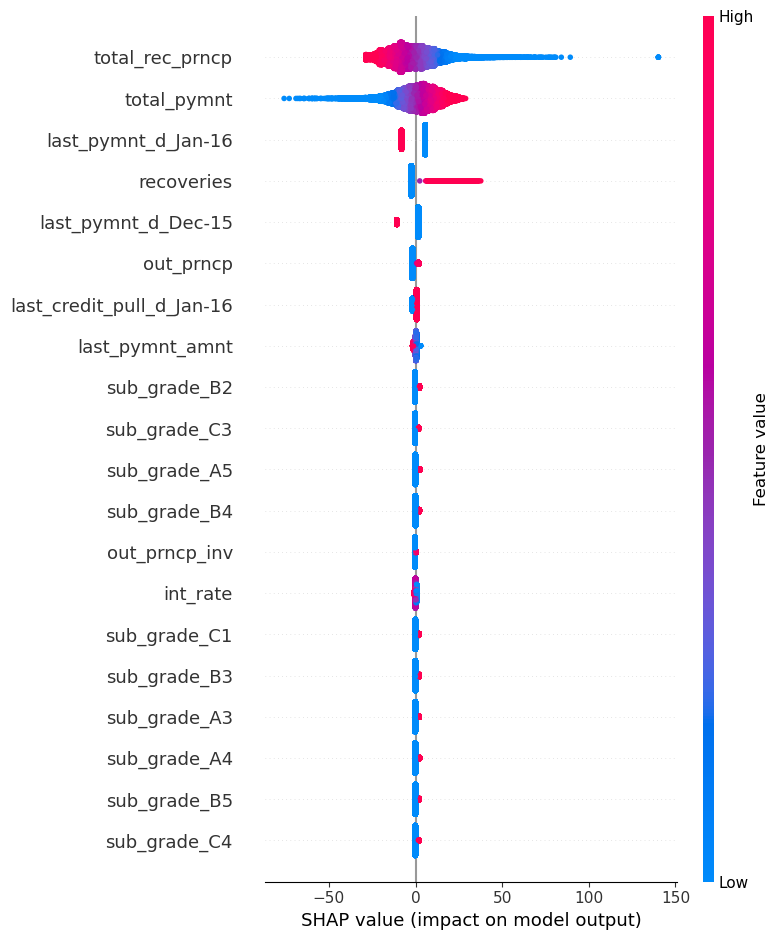

In [19]:
# Set the figure size for the summary plot
plt.figure(figsize=(10, 6))  # Adjust the dimensions as needed
shap.summary_plot(xgb_model_shap_values, X_test)

## 4.2 Waterfall Plot

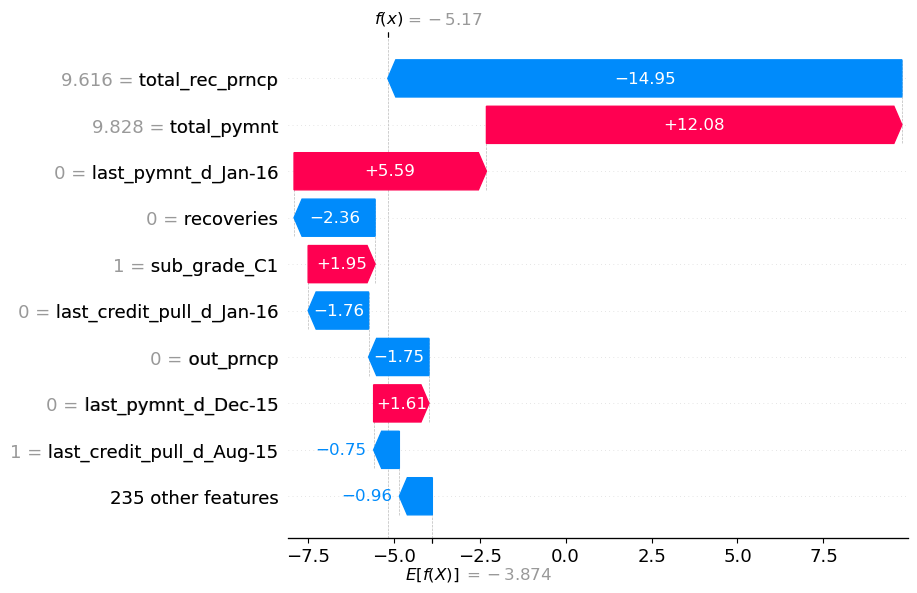

In [20]:
shap.plots.waterfall(xgb_model_shap_values[0]) 

## 4.3 Scatter plot

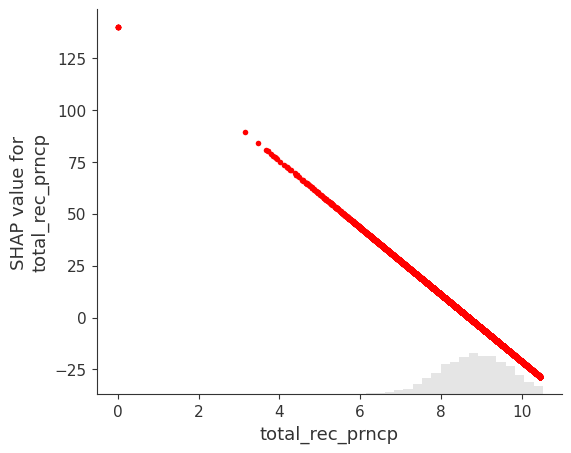

In [21]:
shap.plots.scatter(xgb_model_shap_values[:, 'total_rec_prncp'], color='red')

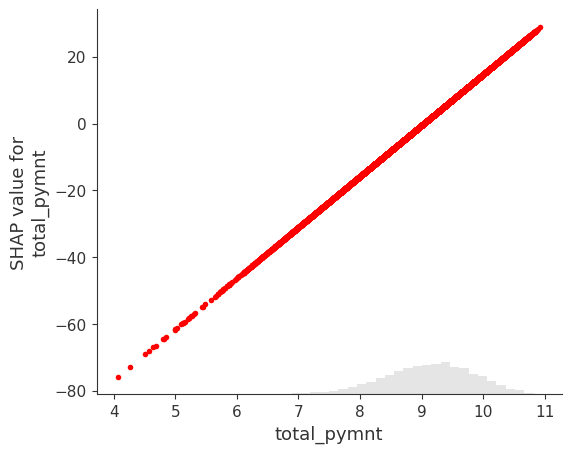

In [22]:
shap.plots.scatter(xgb_model_shap_values[:, 'total_pymnt'], color='red')

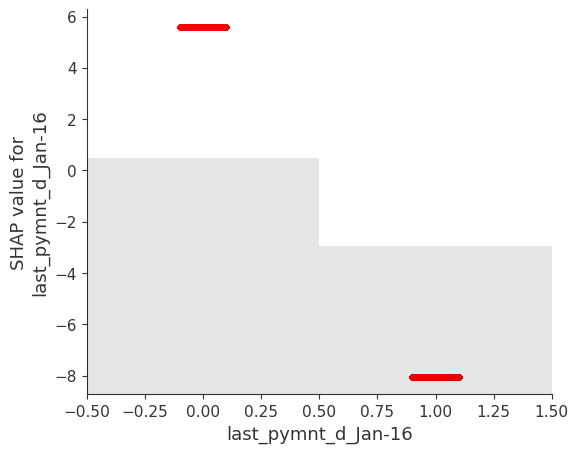

In [23]:
shap.plots.scatter(xgb_model_shap_values[:, 'last_pymnt_d_Jan-16'], color='red')

## 4.4 TreeExplainer


In [26]:
tree_explainer = shap.TreeExplainer(xgb_model)
tree_shap_values = tree_explainer.shap_values(X_test)

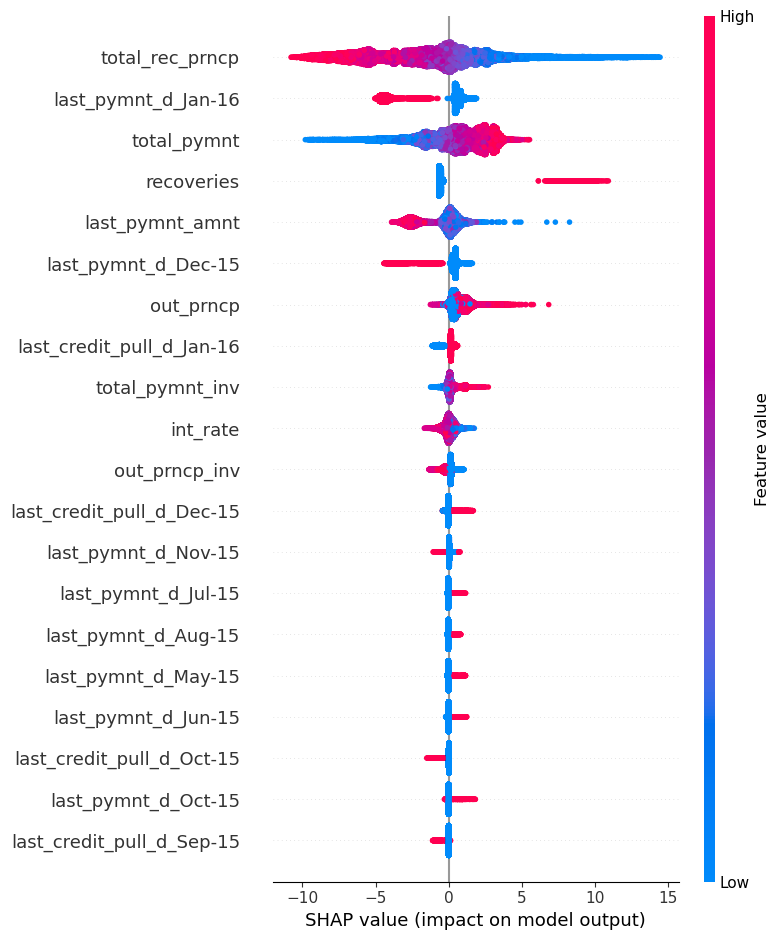

In [27]:
shap.summary_plot(tree_shap_values, X_test)

## 4.5 force_plot

In [31]:
shap.initjs()

In [32]:
shap.force_plot(tree_explainer.expected_value, tree_shap_values[0], X_test.iloc[0, :])

In [33]:
print("Expected value:", tree_explainer.expected_value)

Expected value: -2.89324


The expected value is -2.89324, which is the average model output (log-odds of the positive class) over the training data. This value serves as the baseline for SHAP value calculations.

A negative SHAP value indicates a push towards the negative class (non-default). Which mean selected feature with XBGClassifier turns out to be a negative impact on the model output, with the likelihood of not defaulting.

## 4.6 feature value and shap value

In [54]:
sample_w_shap = pd.DataFrame(X_test.iloc[0, :])
sample_w_shap.rename(columns={0: 'feature_value'}, inplace=True)
sample_w_shap['shap_value'] = tree_shap_values[0]
# rename the first column to feature_value

sample_w_shap.sort_values(by='shap_value', ascending=False, inplace=True)
sample_w_shap.rename(columns={205429: 'feature value', 'shape_value': 'shap value'}, inplace=True)
# display top 5 features with the highest SHAP values
sample_w_shap[:5]

,feature value,shap_value
total_pymnt,9.827760,2.304810
last_pymnt_d_Jan-16,0.000000,0.664006
last_pymnt_amnt,6.256345,0.598233
last_pymnt_d_Dec-15,0.000000,0.413654
total_pymnt_inv,9.827760,0.364560


sample_w_shap

In [56]:
sample_w_shap[-5:]

,feature value,shap_value
last_credit_pull_d_Dec-15,0.000000,-0.196265
recoveries,0.000000,-0.585034
last_credit_pull_d_Aug-15,1.000000,-0.865698
last_credit_pull_d_Jan-16,0.000000,-0.868053
total_rec_prncp,9.615872,-6.568811


# 5. Summary

- **`total_pymnt`**: The positive SHAP value from both models suggests that higher total payments correlate with a higher likelihood of default, potentially indicating loans with larger amounts or longer terms that are inherently riskier.

- **`total_rec_prncp`**: A negative SHAP value indicates that as borrowers repay more of the principal, the risk of default decreases, which aligns with standard credit risk logic where consistent repayment is a sign of loan performance and financial stability.

- **`last_pymnt_d_Jan-16`**: The positive SHAP value implies that the absence of a payment in January 2016 increases the risk of default, highlighting the importance of recent payment behavior as a predictor of loan performance.

From a technical standpoint, both the Logistic Regression and XGBClassifier models identify similar features as significant predictors of default, with `total_pymnt` and `last_pymnt_d_Jan-16` increasing the likelihood of default, while `total_rec_prncp` decreases it. The consistency across both models reinforces the robustness of these features as indicators.

From a financial and credit risk perspective, the models suggest that while larger total payments might reflect larger loan sizes, they could also signal financial distress if coupled with the cessation of recent payments. The repayment of the principal amount is a universally positive sign in credit risk assessment, indicating lower default risk.

The final conclusion is that both models validate the critical role of payment history and loan performance metrics in predicting defaults. These insights can inform risk management strategies, where attention to loan size, payment recency, and principal repayment can help lenders mitigate risk and manage their loan portfolios more effectively.